# Definition and Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Needed Moduels

In [ ]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

## Import Training Data and Labels

In [ ]:
#train data

npzfile = np.load('/content/drive/MyDrive/Georgia_12Lead_ECG_Challenge_Database/train_data.npz')
train_data = npzfile['arr_0']
print('shape of training data -->' , np.shape(train_data))

shape of training data --> (8000, 4000, 12)


In [ ]:
#train label

train_label = pd.read_csv(open('/content/drive/MyDrive/Georgia_12Lead_ECG_Challenge_Database/train_labels.csv'),index_col=0).values
print('shape of training label -->' , np.shape(train_label))

shape of training label --> (8000, 1)


## Import Test Data and Labels

In [ ]:
# importing test data

npzfile = np.load('/content/drive/MyDrive/Georgia_12Lead_ECG_Challenge_Database/test_data.npz')
test_data = npzfile['arr_0']
print('shape of test data -->' , np.shape(test_data))

shape of test data --> (2344, 4000, 12)


In [ ]:
#importing test label

test_label = pd.read_csv(open('/content/drive/MyDrive/Georgia_12Lead_ECG_Challenge_Database/test_label.csv'),index_col=0).values
print('shape of test label -->' , np.shape(test_label))

shape of test label --> (2344, 1)


## SkFold Preprepation

In [ ]:
skf = StratifiedKFold(n_splits=10 , shuffle = True , random_state = 42)
train_indices = []
test_indices = []

for train_index, test_index in skf.split(train_data, train_label):
  train_indices.append(train_index)
  test_indices.append(test_index)

train_indices

[array([   0,    1,    2, ..., 7997, 7998, 7999]),
 array([   1,    2,    3, ..., 7996, 7998, 7999]),
 array([   0,    1,    4, ..., 7997, 7998, 7999]),
 array([   0,    1,    2, ..., 7997, 7998, 7999]),
 array([   0,    1,    2, ..., 7997, 7998, 7999]),
 array([   0,    2,    3, ..., 7997, 7998, 7999]),
 array([   0,    1,    2, ..., 7997, 7998, 7999]),
 array([   0,    1,    2, ..., 7997, 7998, 7999]),
 array([   0,    1,    2, ..., 7997, 7998, 7999]),
 array([   0,    1,    2, ..., 7995, 7996, 7997])]

## Usefull Functions

In [ ]:
# find specificity
def specificity_score(y_true, y_pred):
    m = confusion_matrix(y_true, y_pred, labels=[0, 1])
    spc = m[0, 0] * 1.0 / (m[0, 0] + m[0, 1])
    return spc

# find sensitivity
def sensitivity_score(y_true, y_pred):
    m = confusion_matrix(y_true, y_pred, labels=[0, 1])
    sen = m[1,1] * 1.0 / (m[1,1] + m[1,0])
    return sen

# find optimal threshold
def find_opt_thresh(label , prediction):
  opt_threshold = []

  # Get precision-recall curve
  precision, recall, threshold = precision_recall_curve(label, prediction)

  # Compute f1 score for each point (use nan_to_num to avoid nans messing up the results)
  f1_score = np.nan_to_num(2 * precision * recall / (precision + recall))

  # Select threshold that maximize f1 score
  index = np.argmax(f1_score)
  t = threshold[index-1] if index != 0 else threshold[0]-1e-10
  opt_threshold.append(t)

  return opt_threshold

# Train Model

### Define Model

In [ ]:
from keras.layers import Flatten, Activation, RepeatVector, Permute, Multiply, Lambda, Dense, merge
from keras import backend as K

def ConvAttentionModel():
  input_layer = tf.keras.layers.Input(shape = [4000,12])
  x = tf.keras.layers.Conv1D(filters=16 , kernel_size=2 , padding='causal' , activation='relu' , dilation_rate=1)(input_layer)
  for rate in (2,4,8,16,32,64,128,256,512):
    x = tf.keras.layers.Conv1D(filters=16 , kernel_size=2 , padding='causal' , activation='relu' , dilation_rate=rate)(x)
  for rate in (1,2,4,8,16,32,64,128,256,512):
    x = tf.keras.layers.Conv1D(filters=32 , kernel_size=2 , padding='causal' , activation='relu' , dilation_rate=rate)(x)
  for rate in (1,2,4,8,16,32,64,128,256,512):
    x = tf.keras.layers.Conv1D(filters=64 , kernel_size=2 , padding='causal' , activation='relu' , dilation_rate=rate)(x)
  x = tf.keras.layers.Conv1D(filters=64 , kernel_size=1)(x)
  x = tf.keras.layers.MaxPooling1D(2)(x)
  '''
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dropout(rate = 0.2)(x)
  '''
  # Attention mechanism
  # -----------------
  e = tf.keras.layers.Dense(1, activation='tanh')(x)
  e = tf.keras.layers.Flatten()(e)
  a = tf.keras.layers.Activation('softmax')(e)
  temp=RepeatVector(64)(a)
  temp=Permute([2, 1])(temp)
  output = merge.Multiply()([x, temp])
  output = Lambda(lambda values: K.sum(values, axis=1))(output)
  # -----------------

  output_layer = tf.keras.layers.Dense(1 , activation='sigmoid')(output)
 
  return tf.keras.Model(inputs = input_layer , outputs = output_layer)


In [ ]:
model_design = ConvAttentionModel()
model_design.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4000, 12)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4000, 16)     400         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4000, 16)     528         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 4000, 16)     528         conv1d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
def CompModel():
  model = ConvAttentionModel()
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05) , 
                loss='binary_crossentropy' , metrics=['acc'])
  return model
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10 , restore_best_weights=True)

#### Fold 1

In [ ]:
model = CompModel()

In [ ]:
history = model.fit(train_data[train_indices[0]], train_label[train_indices[0]],
            epochs=1000,
            validation_data = (train_data[test_indices[0]] , train_label[test_indices[0]]),
            callbacks = [early_stopping_cb],
            verbose = 1)

Epoch 1/1000
225/225 [==============================] - 44s 113ms/step - loss: 0.6747 - acc: 0.9732 - val_loss: 0.6364 - val_acc: 0.9787
Epoch 2/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.3922 - acc: 0.9776 - val_loss: 0.1179 - val_acc: 0.9787
Epoch 3/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1165 - acc: 0.9776 - val_loss: 0.1101 - val_acc: 0.9787
Epoch 4/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1126 - acc: 0.9776 - val_loss: 0.1076 - val_acc: 0.9787
Epoch 5/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1106 - acc: 0.9776 - val_loss: 0.1056 - val_acc: 0.9787
Epoch 6/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1090 - acc: 0.9776 - val_loss: 0.1039 - val_acc: 0.9787
Epoch 7/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1074 - acc: 0.9776 - val_loss: 0.1021 - val_acc: 0.9787
Epoch 8/1000
225/225 [===================

In [ ]:
model.save('/content/drive/MyDrive/final_models/with_attention/model1.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


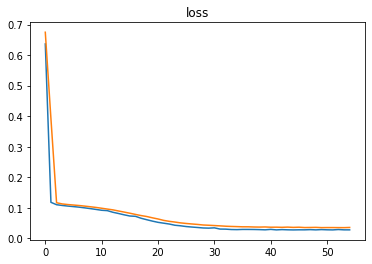

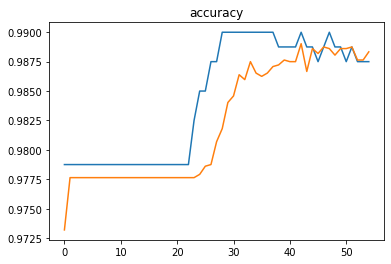

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot acc and loss
import matplotlib.pyplot as plt
epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['val_loss'])
plt.plot(epochs , history.history['loss'])
plt.title('loss')
plt.figure()
plt.plot(epochs , history.history['val_acc'])
plt.plot(epochs , history.history['acc'])
plt.title('accuracy')
plt.figure()
plt.show()

In [ ]:
model.evaluate(test_data , test_label)

74/74 [==============================] - 4s 41ms/step - loss: 0.0382 - acc: 0.9872


[0.03824635595083237, 0.9872013926506042]

In [ ]:
# performance measurements on test data 2

pred = model.predict(test_data)

thresh = find_opt_thresh(test_label , pred)
print(thresh)
prediction = np.zeros(np.shape(pred))
prediction[pred > thresh] = 1

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_label   , prediction)
print('accuracy is:' , np.round(accuracy*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import precision_score
pscore = precision_score(test_label   , prediction)
print('precision score is:' , np.round(pscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import recall_score
rscore = recall_score(test_label   , prediction)
print('recall score is:' , np.round(rscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import f1_score
fscore = f1_score(test_label   , prediction)
print('f1 score is:' , np.round(fscore*100,2) , '%')
print('___________________________________________')
spc = specificity_score(test_label   , prediction)
print('specificity is:' , np.round(spc*100,2) , '%')
print('___________________________________________')
sen = sensitivity_score(test_label   , prediction)
print('sensitivity is:' , np.round(sen*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_label   , prediction)
print('AUC is:' , np.round(auc,4))

[0.57995427]
accuracy is: 98.85 %
___________________________________________
precision score is: 77.08 %
___________________________________________
recall score is: 69.81 %
___________________________________________
f1 score is: 73.27 %
___________________________________________
specificity is: 99.52 %
___________________________________________
sensitivity is: 69.81 %
___________________________________________
AUC is: 0.8467


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


#### Fold 2

In [ ]:
model = CompModel()

In [ ]:
history = model.fit(train_data[train_indices[1]], train_label[train_indices[1]],
            epochs=1000,
            validation_data = (train_data[test_indices[1]] , train_label[test_indices[1]]),
            callbacks = [early_stopping_cb],
            verbose = 1)

Epoch 1/1000
225/225 [==============================] - 28s 113ms/step - loss: 0.6712 - acc: 0.9735 - val_loss: 0.6245 - val_acc: 0.9787
Epoch 2/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.3689 - acc: 0.9776 - val_loss: 0.1100 - val_acc: 0.9787
Epoch 3/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1101 - acc: 0.9776 - val_loss: 0.1044 - val_acc: 0.9787
Epoch 4/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1085 - acc: 0.9776 - val_loss: 0.1045 - val_acc: 0.9787
Epoch 5/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1077 - acc: 0.9776 - val_loss: 0.1031 - val_acc: 0.9787
Epoch 6/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1072 - acc: 0.9776 - val_loss: 0.1023 - val_acc: 0.9787
Epoch 7/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1062 - acc: 0.9776 - val_loss: 0.1013 - val_acc: 0.9787
Epoch 8/1000
225/225 [===================

In [ ]:
model.save('/content/drive/MyDrive/final_models/with_attention/model2.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


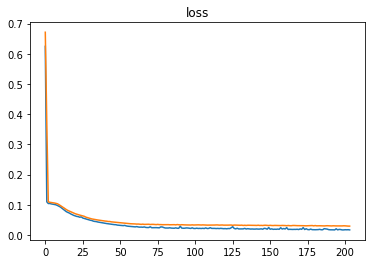

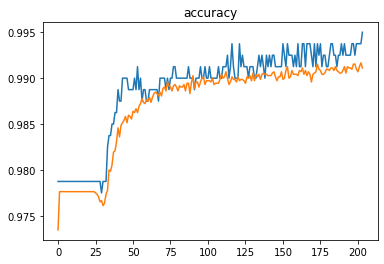

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot acc and loss
import matplotlib.pyplot as plt
epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['val_loss'])
plt.plot(epochs , history.history['loss'])
plt.title('loss')
plt.figure()
plt.plot(epochs , history.history['val_acc'])
plt.plot(epochs , history.history['acc'])
plt.title('accuracy')
plt.figure()
plt.show()

In [ ]:
model.evaluate(test_data , test_label)

74/74 [==============================] - 3s 37ms/step - loss: 0.0350 - acc: 0.9889


[0.03502235561609268, 0.9889078736305237]

In [ ]:
# performance measurements on test data 2

pred = model.predict(test_data)

thresh = find_opt_thresh(test_label , pred)
print(thresh)
prediction = np.zeros(np.shape(pred))
prediction[pred > thresh] = 1

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_label   , prediction)
print('accuracy is:' , np.round(accuracy*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import precision_score
pscore = precision_score(test_label   , prediction)
print('precision score is:' , np.round(pscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import recall_score
rscore = recall_score(test_label   , prediction)
print('recall score is:' , np.round(rscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import f1_score
fscore = f1_score(test_label   , prediction)
print('f1 score is:' , np.round(fscore*100,2) , '%')
print('___________________________________________')
spc = specificity_score(test_label   , prediction)
print('specificity is:' , np.round(spc*100,2) , '%')
print('___________________________________________')
sen = sensitivity_score(test_label   , prediction)
print('sensitivity is:' , np.round(sen*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_label   , prediction)
print('AUC is:' , np.round(auc,4))

[0.11051233]
accuracy is: 98.85 %
___________________________________________
precision score is: 69.7 %
___________________________________________
recall score is: 86.79 %
___________________________________________
f1 score is: 77.31 %
___________________________________________
specificity is: 99.13 %
___________________________________________
sensitivity is: 86.79 %
___________________________________________
AUC is: 0.9296


#### Fold 3

In [ ]:
model = CompModel()

In [ ]:
history = model.fit(train_data[train_indices[2]], train_label[train_indices[2]],
            epochs=1000,
            validation_data = (train_data[test_indices[2]] , train_label[test_indices[2]]),
            callbacks = [early_stopping_cb],
            verbose = 1)

Epoch 1/1000
225/225 [==============================] - 29s 115ms/step - loss: 0.6749 - acc: 0.9778 - val_loss: 0.6368 - val_acc: 0.9775
Epoch 2/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.3950 - acc: 0.9778 - val_loss: 0.1190 - val_acc: 0.9775
Epoch 3/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1143 - acc: 0.9778 - val_loss: 0.1119 - val_acc: 0.9775
Epoch 4/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1119 - acc: 0.9778 - val_loss: 0.1108 - val_acc: 0.9775
Epoch 5/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1105 - acc: 0.9778 - val_loss: 0.1098 - val_acc: 0.9775
Epoch 6/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1091 - acc: 0.9778 - val_loss: 0.1089 - val_acc: 0.9775
Epoch 7/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1082 - acc: 0.9778 - val_loss: 0.1082 - val_acc: 0.9775
Epoch 8/1000
225/225 [===================

In [ ]:
model.save('/content/drive/MyDrive/final_models/with_attention/model3.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


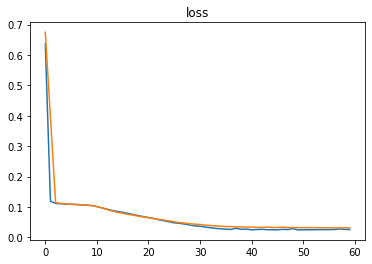

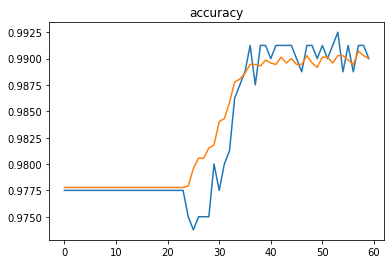

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot acc and loss
import matplotlib.pyplot as plt
epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['val_loss'])
plt.plot(epochs , history.history['loss'])
plt.title('loss')
plt.figure()
plt.plot(epochs , history.history['val_acc'])
plt.plot(epochs , history.history['acc'])
plt.title('accuracy')
plt.figure()
plt.show()

In [ ]:
model.evaluate(test_data , test_label)

74/74 [==============================] - 3s 37ms/step - loss: 0.0337 - acc: 0.9889


[0.03369024395942688, 0.9889078736305237]

In [ ]:
# performance measurements on test data 2

pred = model.predict(test_data)

thresh = find_opt_thresh(test_label , pred)
print(thresh)
prediction = np.zeros(np.shape(pred))
prediction[pred > thresh] = 1

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_label   , prediction)
print('accuracy is:' , np.round(accuracy*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import precision_score
pscore = precision_score(test_label   , prediction)
print('precision score is:' , np.round(pscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import recall_score
rscore = recall_score(test_label   , prediction)
print('recall score is:' , np.round(rscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import f1_score
fscore = f1_score(test_label   , prediction)
print('f1 score is:' , np.round(fscore*100,2) , '%')
print('___________________________________________')
spc = specificity_score(test_label   , prediction)
print('specificity is:' , np.round(spc*100,2) , '%')
print('___________________________________________')
sen = sensitivity_score(test_label   , prediction)
print('sensitivity is:' , np.round(sen*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_label   , prediction)
print('AUC is:' , np.round(auc,4))

[0.5123091]
accuracy is: 98.93 %
___________________________________________
precision score is: 73.33 %
___________________________________________
recall score is: 83.02 %
___________________________________________
f1 score is: 77.88 %
___________________________________________
specificity is: 99.3 %
___________________________________________
sensitivity is: 83.02 %
___________________________________________
AUC is: 0.9116


#### Fold 4

In [ ]:
model = CompModel()

In [ ]:
history = model.fit(train_data[train_indices[3]], train_label[train_indices[3]],
            epochs=1000,
            validation_data = (train_data[test_indices[3]] , train_label[test_indices[3]]),
            callbacks = [early_stopping_cb],
            verbose = 1)

Epoch 1/1000
225/225 [==============================] - 28s 113ms/step - loss: 0.6691 - acc: 0.9778 - val_loss: 0.6156 - val_acc: 0.9775
Epoch 2/1000
225/225 [==============================] - 24s 109ms/step - loss: 0.3442 - acc: 0.9778 - val_loss: 0.1187 - val_acc: 0.9775
Epoch 3/1000
225/225 [==============================] - 25s 109ms/step - loss: 0.1139 - acc: 0.9778 - val_loss: 0.1124 - val_acc: 0.9775
Epoch 4/1000
225/225 [==============================] - 25s 109ms/step - loss: 0.1106 - acc: 0.9778 - val_loss: 0.1108 - val_acc: 0.9775
Epoch 5/1000
225/225 [==============================] - 24s 109ms/step - loss: 0.1092 - acc: 0.9778 - val_loss: 0.1091 - val_acc: 0.9775
Epoch 6/1000
225/225 [==============================] - 24s 109ms/step - loss: 0.1076 - acc: 0.9778 - val_loss: 0.1084 - val_acc: 0.9775
Epoch 7/1000
225/225 [==============================] - 25s 109ms/step - loss: 0.1069 - acc: 0.9778 - val_loss: 0.1070 - val_acc: 0.9775
Epoch 8/1000
225/225 [===================

In [ ]:
model.save('/content/drive/MyDrive/final_models/with_attention/model4.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


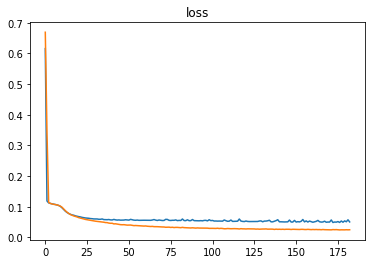

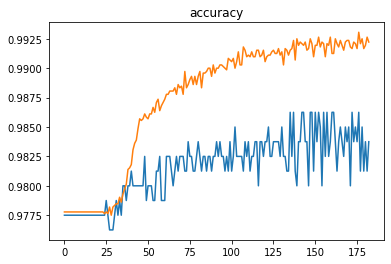

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot acc and loss
import matplotlib.pyplot as plt
epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['val_loss'])
plt.plot(epochs , history.history['loss'])
plt.title('loss')
plt.figure()
plt.plot(epochs , history.history['val_acc'])
plt.plot(epochs , history.history['acc'])
plt.title('accuracy')
plt.figure()
plt.show()

In [ ]:
model.evaluate(test_data , test_label)

74/74 [==============================] - 3s 37ms/step - loss: 0.0354 - acc: 0.9889


[0.035442981868982315, 0.9889078736305237]

In [ ]:
# performance measurements on test data 2

pred = model.predict(test_data)

thresh = find_opt_thresh(test_label , pred)
print(thresh)
prediction = np.zeros(np.shape(pred))
prediction[pred > thresh] = 1

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_label   , prediction)
print('accuracy is:' , np.round(accuracy*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import precision_score
pscore = precision_score(test_label   , prediction)
print('precision score is:' , np.round(pscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import recall_score
rscore = recall_score(test_label   , prediction)
print('recall score is:' , np.round(rscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import f1_score
fscore = f1_score(test_label   , prediction)
print('f1 score is:' , np.round(fscore*100,2) , '%')
print('___________________________________________')
spc = specificity_score(test_label   , prediction)
print('specificity is:' , np.round(spc*100,2) , '%')
print('___________________________________________')
sen = sensitivity_score(test_label   , prediction)
print('sensitivity is:' , np.round(sen*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_label   , prediction)
print('AUC is:' , np.round(auc,4))

[0.53763443]
accuracy is: 98.98 %
___________________________________________
precision score is: 77.36 %
___________________________________________
recall score is: 77.36 %
___________________________________________
f1 score is: 77.36 %
___________________________________________
specificity is: 99.48 %
___________________________________________
sensitivity is: 77.36 %
___________________________________________
AUC is: 0.8842


#### Fold 5

In [ ]:
model = CompModel()

In [ ]:
history = model.fit(train_data[train_indices[4]], train_label[train_indices[4]],
            epochs=1000,
            validation_data = (train_data[test_indices[4]] , train_label[test_indices[4]]),
            callbacks = [early_stopping_cb],
            verbose = 1)

Epoch 1/1000
225/225 [==============================] - 28s 114ms/step - loss: 0.6755 - acc: 0.9733 - val_loss: 0.6412 - val_acc: 0.9775
Epoch 2/1000
225/225 [==============================] - 25s 111ms/step - loss: 0.4004 - acc: 0.9778 - val_loss: 0.1276 - val_acc: 0.9775
Epoch 3/1000
225/225 [==============================] - 25s 111ms/step - loss: 0.1227 - acc: 0.9778 - val_loss: 0.1187 - val_acc: 0.9775
Epoch 4/1000
225/225 [==============================] - 25s 111ms/step - loss: 0.1176 - acc: 0.9778 - val_loss: 0.1158 - val_acc: 0.9775
Epoch 5/1000
225/225 [==============================] - 25s 111ms/step - loss: 0.1151 - acc: 0.9778 - val_loss: 0.1139 - val_acc: 0.9775
Epoch 6/1000
225/225 [==============================] - 25s 111ms/step - loss: 0.1135 - acc: 0.9778 - val_loss: 0.1126 - val_acc: 0.9775
Epoch 7/1000
225/225 [==============================] - 25s 111ms/step - loss: 0.1119 - acc: 0.9778 - val_loss: 0.1115 - val_acc: 0.9775
Epoch 8/1000
225/225 [===================

In [ ]:
model.save('/content/drive/MyDrive/final_models/with_attention/model5.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


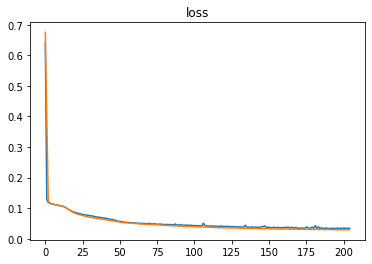

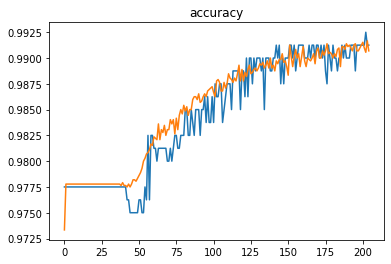

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot acc and loss
import matplotlib.pyplot as plt
epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['val_loss'])
plt.plot(epochs , history.history['loss'])
plt.title('loss')
plt.figure()
plt.plot(epochs , history.history['val_acc'])
plt.plot(epochs , history.history['acc'])
plt.title('accuracy')
plt.figure()
plt.show()

In [ ]:
model.evaluate(test_data , test_label)

74/74 [==============================] - 3s 37ms/step - loss: 0.0362 - acc: 0.9872


[0.036203570663928986, 0.9872013926506042]

In [ ]:
# performance measurements on test data 2

pred = model.predict(test_data)

thresh = find_opt_thresh(test_label , pred)
print(thresh)
prediction = np.zeros(np.shape(pred))
prediction[pred > thresh] = 1

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_label   , prediction)
print('accuracy is:' , np.round(accuracy*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import precision_score
pscore = precision_score(test_label   , prediction)
print('precision score is:' , np.round(pscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import recall_score
rscore = recall_score(test_label   , prediction)
print('recall score is:' , np.round(rscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import f1_score
fscore = f1_score(test_label   , prediction)
print('f1 score is:' , np.round(fscore*100,2) , '%')
print('___________________________________________')
spc = specificity_score(test_label   , prediction)
print('specificity is:' , np.round(spc*100,2) , '%')
print('___________________________________________')
sen = sensitivity_score(test_label   , prediction)
print('sensitivity is:' , np.round(sen*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_label   , prediction)
print('AUC is:' , np.round(auc,4))

[0.5073751]
accuracy is: 98.76 %
___________________________________________
precision score is: 71.43 %
___________________________________________
recall score is: 75.47 %
___________________________________________
f1 score is: 73.39 %
___________________________________________
specificity is: 99.3 %
___________________________________________
sensitivity is: 75.47 %
___________________________________________
AUC is: 0.8739


#### Fold 6

In [ ]:
model = CompModel()

In [ ]:
history = model.fit(train_data[train_indices[5]], train_label[train_indices[5]],
            epochs=1000,
            validation_data = (train_data[test_indices[5]] , train_label[test_indices[5]]),
            callbacks = [early_stopping_cb],
            verbose = 1)

Epoch 1/1000
225/225 [==============================] - 28s 115ms/step - loss: 0.6758 - acc: 0.9778 - val_loss: 0.6380 - val_acc: 0.9775
Epoch 2/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.3632 - acc: 0.9778 - val_loss: 0.1367 - val_acc: 0.9775
Epoch 3/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1296 - acc: 0.9778 - val_loss: 0.1285 - val_acc: 0.9775
Epoch 4/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1249 - acc: 0.9778 - val_loss: 0.1251 - val_acc: 0.9775
Epoch 5/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1219 - acc: 0.9778 - val_loss: 0.1224 - val_acc: 0.9775
Epoch 6/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1193 - acc: 0.9778 - val_loss: 0.1204 - val_acc: 0.9775
Epoch 7/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1173 - acc: 0.9778 - val_loss: 0.1180 - val_acc: 0.9775
Epoch 8/1000
225/225 [===================

In [ ]:
model.save('/content/drive/MyDrive/final_models/with_attention/model6.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


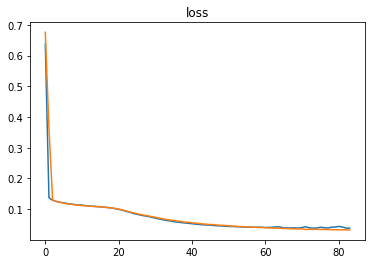

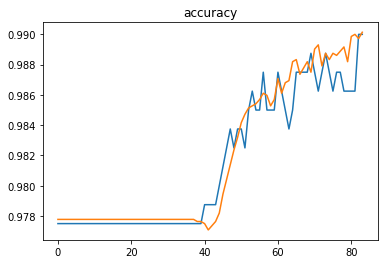

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot acc and loss
import matplotlib.pyplot as plt
epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['val_loss'])
plt.plot(epochs , history.history['loss'])
plt.title('loss')
plt.figure()
plt.plot(epochs , history.history['val_acc'])
plt.plot(epochs , history.history['acc'])
plt.title('accuracy')
plt.figure()
plt.show()

In [ ]:
model.evaluate(test_data , test_label)

74/74 [==============================] - 3s 36ms/step - loss: 0.0340 - acc: 0.9889


[0.034002166241407394, 0.9889078736305237]

In [ ]:
# performance measurements on test data 2

pred = model.predict(test_data)

thresh = find_opt_thresh(test_label , pred)
print(thresh)
prediction = np.zeros(np.shape(pred))
prediction[pred > thresh] = 1

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_label   , prediction)
print('accuracy is:' , np.round(accuracy*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import precision_score
pscore = precision_score(test_label   , prediction)
print('precision score is:' , np.round(pscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import recall_score
rscore = recall_score(test_label   , prediction)
print('recall score is:' , np.round(rscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import f1_score
fscore = f1_score(test_label   , prediction)
print('f1 score is:' , np.round(fscore*100,2) , '%')
print('___________________________________________')
spc = specificity_score(test_label   , prediction)
print('specificity is:' , np.round(spc*100,2) , '%')
print('___________________________________________')
sen = sensitivity_score(test_label   , prediction)
print('sensitivity is:' , np.round(sen*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_label   , prediction)
print('AUC is:' , np.round(auc,4))

[0.47863546]
accuracy is: 98.93 %
___________________________________________
precision score is: 75.93 %
___________________________________________
recall score is: 77.36 %
___________________________________________
f1 score is: 76.64 %
___________________________________________
specificity is: 99.43 %
___________________________________________
sensitivity is: 77.36 %
___________________________________________
AUC is: 0.884


#### Fold 7

In [ ]:
model = CompModel()

In [ ]:
history = model.fit(train_data[train_indices[6]], train_label[train_indices[6]],
            epochs=1000,
            validation_data = (train_data[test_indices[6]] , train_label[test_indices[6]]),
            callbacks = [early_stopping_cb],
            verbose = 1)

Epoch 1/1000
225/225 [==============================] - 46s 117ms/step - loss: 0.6689 - acc: 0.9739 - val_loss: 0.6181 - val_acc: 0.9775
Epoch 2/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.3432 - acc: 0.9778 - val_loss: 0.1260 - val_acc: 0.9775
Epoch 3/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1274 - acc: 0.9778 - val_loss: 0.1193 - val_acc: 0.9775
Epoch 4/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1223 - acc: 0.9778 - val_loss: 0.1163 - val_acc: 0.9775
Epoch 5/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1187 - acc: 0.9778 - val_loss: 0.1145 - val_acc: 0.9775
Epoch 6/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1158 - acc: 0.9778 - val_loss: 0.1124 - val_acc: 0.9775
Epoch 7/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1137 - acc: 0.9778 - val_loss: 0.1111 - val_acc: 0.9775
Epoch 8/1000
225/225 [===================

In [ ]:
model.save('/content/drive/MyDrive/final_models/with_attention/model7.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


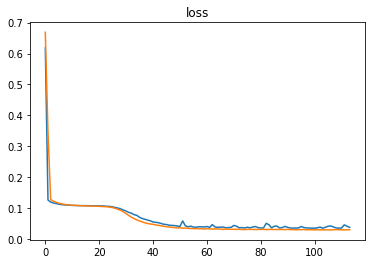

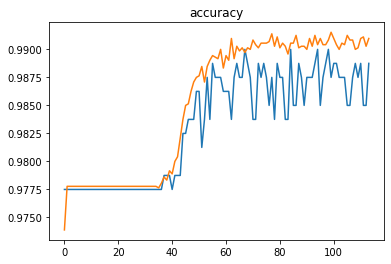

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot acc and loss
import matplotlib.pyplot as plt
epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['val_loss'])
plt.plot(epochs , history.history['loss'])
plt.title('loss')
plt.figure()
plt.plot(epochs , history.history['val_acc'])
plt.plot(epochs , history.history['acc'])
plt.title('accuracy')
plt.figure()
plt.show()

In [ ]:
model.evaluate(test_data , test_label)

74/74 [==============================] - 4s 42ms/step - loss: 0.0328 - acc: 0.9881


[0.03281950205564499, 0.988054633140564]

In [ ]:
# performance measurements on test data 2

pred = model.predict(test_data)

thresh = find_opt_thresh(test_label , pred)
print(thresh)
prediction = np.zeros(np.shape(pred))
prediction[pred > thresh] = 1

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_label   , prediction)
print('accuracy is:' , np.round(accuracy*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import precision_score
pscore = precision_score(test_label   , prediction)
print('precision score is:' , np.round(pscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import recall_score
rscore = recall_score(test_label   , prediction)
print('recall score is:' , np.round(rscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import f1_score
fscore = f1_score(test_label   , prediction)
print('f1 score is:' , np.round(fscore*100,2) , '%')
print('___________________________________________')
spc = specificity_score(test_label   , prediction)
print('specificity is:' , np.round(spc*100,2) , '%')
print('___________________________________________')
sen = sensitivity_score(test_label   , prediction)
print('sensitivity is:' , np.round(sen*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_label   , prediction)
print('AUC is:' , np.round(auc,4))

[0.3256756]
accuracy is: 98.89 %
___________________________________________
precision score is: 70.15 %
___________________________________________
recall score is: 88.68 %
___________________________________________
f1 score is: 78.33 %
___________________________________________
specificity is: 99.13 %
___________________________________________
sensitivity is: 88.68 %
___________________________________________
AUC is: 0.939


#### Fold 8

In [ ]:
model = CompModel()

In [ ]:
history = model.fit(train_data[train_indices[7]], train_label[train_indices[7]],
            epochs=1000,
            validation_data = (train_data[test_indices[7]] , train_label[test_indices[7]]),
            callbacks = [early_stopping_cb],
            verbose = 1)

Epoch 1/1000
225/225 [==============================] - 30s 116ms/step - loss: 0.6735 - acc: 0.9736 - val_loss: 0.6238 - val_acc: 0.9775
Epoch 2/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.3206 - acc: 0.9778 - val_loss: 0.1285 - val_acc: 0.9775
Epoch 3/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1199 - acc: 0.9778 - val_loss: 0.1239 - val_acc: 0.9775
Epoch 4/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1166 - acc: 0.9778 - val_loss: 0.1197 - val_acc: 0.9775
Epoch 5/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1142 - acc: 0.9778 - val_loss: 0.1171 - val_acc: 0.9775
Epoch 6/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1125 - acc: 0.9778 - val_loss: 0.1150 - val_acc: 0.9775
Epoch 7/1000
225/225 [==============================] - 25s 112ms/step - loss: 0.1110 - acc: 0.9778 - val_loss: 0.1136 - val_acc: 0.9775
Epoch 8/1000
225/225 [===================

In [ ]:
model.save('/content/drive/MyDrive/final_models/with_attention/model8.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


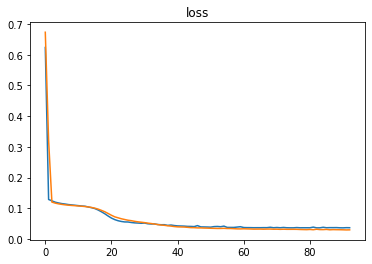

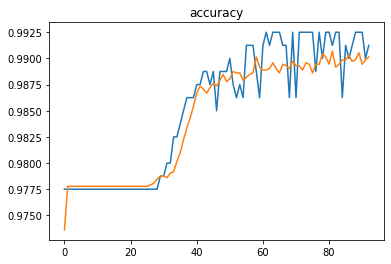

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot acc and loss
import matplotlib.pyplot as plt
epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['val_loss'])
plt.plot(epochs , history.history['loss'])
plt.title('loss')
plt.figure()
plt.plot(epochs , history.history['val_acc'])
plt.plot(epochs , history.history['acc'])
plt.title('accuracy')
plt.figure()
plt.show()

In [ ]:
model.evaluate(test_data , test_label)

74/74 [==============================] - 4s 37ms/step - loss: 0.0341 - acc: 0.9872


[0.034136295318603516, 0.9872013926506042]

In [ ]:
# performance measurements on test data 2

pred = model.predict(test_data)

thresh = find_opt_thresh(test_label , pred)
print(thresh)
prediction = np.zeros(np.shape(pred))
prediction[pred > thresh] = 1

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_label   , prediction)
print('accuracy is:' , np.round(accuracy*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import precision_score
pscore = precision_score(test_label   , prediction)
print('precision score is:' , np.round(pscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import recall_score
rscore = recall_score(test_label   , prediction)
print('recall score is:' , np.round(rscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import f1_score
fscore = f1_score(test_label   , prediction)
print('f1 score is:' , np.round(fscore*100,2) , '%')
print('___________________________________________')
spc = specificity_score(test_label   , prediction)
print('specificity is:' , np.round(spc*100,2) , '%')
print('___________________________________________')
sen = sensitivity_score(test_label   , prediction)
print('sensitivity is:' , np.round(sen*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_label   , prediction)
print('AUC is:' , np.round(auc,4))

[0.2969392]
accuracy is: 98.89 %
___________________________________________
precision score is: 72.13 %
___________________________________________
recall score is: 83.02 %
___________________________________________
f1 score is: 77.19 %
___________________________________________
specificity is: 99.26 %
___________________________________________
sensitivity is: 83.02 %
___________________________________________
AUC is: 0.9114


#### Fold 9

In [ ]:
model = CompModel()

In [ ]:
history = model.fit(train_data[train_indices[8]], train_label[train_indices[8]],
            epochs=1000,
            validation_data = (train_data[test_indices[8]] , train_label[test_indices[8]]),
            callbacks = [early_stopping_cb],
            verbose = 1)

Epoch 1/1000
225/225 [==============================] - 29s 115ms/step - loss: 0.6755 - acc: 0.9778 - val_loss: 0.6384 - val_acc: 0.9775
Epoch 2/1000
225/225 [==============================] - 25s 109ms/step - loss: 0.3904 - acc: 0.9778 - val_loss: 0.1347 - val_acc: 0.9775
Epoch 3/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1253 - acc: 0.9778 - val_loss: 0.1268 - val_acc: 0.9775
Epoch 4/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1202 - acc: 0.9778 - val_loss: 0.1230 - val_acc: 0.9775
Epoch 5/1000
225/225 [==============================] - 25s 109ms/step - loss: 0.1173 - acc: 0.9778 - val_loss: 0.1186 - val_acc: 0.9775
Epoch 6/1000
225/225 [==============================] - 25s 109ms/step - loss: 0.1147 - acc: 0.9778 - val_loss: 0.1160 - val_acc: 0.9775
Epoch 7/1000
225/225 [==============================] - 25s 109ms/step - loss: 0.1128 - acc: 0.9778 - val_loss: 0.1141 - val_acc: 0.9775
Epoch 8/1000
225/225 [===================

In [ ]:
model.save('/content/drive/MyDrive/final_models/with_attention/model9.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


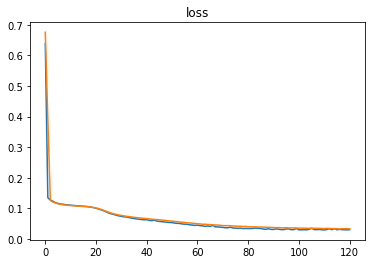

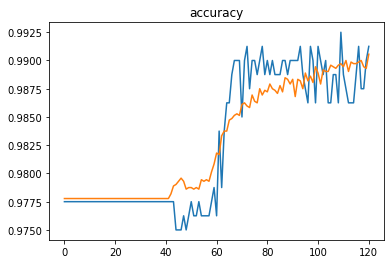

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot acc and loss
import matplotlib.pyplot as plt
epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['val_loss'])
plt.plot(epochs , history.history['loss'])
plt.title('loss')
plt.figure()
plt.plot(epochs , history.history['val_acc'])
plt.plot(epochs , history.history['acc'])
plt.title('accuracy')
plt.figure()
plt.show()

In [ ]:
model.evaluate(test_data , test_label)

74/74 [==============================] - 4s 37ms/step - loss: 0.0354 - acc: 0.9876


[0.03542938455939293, 0.9876279830932617]

In [ ]:
# performance measurements on test data 2

pred = model.predict(test_data)

thresh = find_opt_thresh(test_label , pred)
print(thresh)
prediction = np.zeros(np.shape(pred))
prediction[pred > thresh] = 1

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_label   , prediction)
print('accuracy is:' , np.round(accuracy*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import precision_score
pscore = precision_score(test_label   , prediction)
print('precision score is:' , np.round(pscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import recall_score
rscore = recall_score(test_label   , prediction)
print('recall score is:' , np.round(rscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import f1_score
fscore = f1_score(test_label   , prediction)
print('f1 score is:' , np.round(fscore*100,2) , '%')
print('___________________________________________')
spc = specificity_score(test_label   , prediction)
print('specificity is:' , np.round(spc*100,2) , '%')
print('___________________________________________')
sen = sensitivity_score(test_label   , prediction)
print('sensitivity is:' , np.round(sen*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_label   , prediction)
print('AUC is:' , np.round(auc,4))

[0.4620613]
accuracy is: 98.85 %
___________________________________________
precision score is: 76.0 %
___________________________________________
recall score is: 71.7 %
___________________________________________
f1 score is: 73.79 %
___________________________________________
specificity is: 99.48 %
___________________________________________
sensitivity is: 71.7 %
___________________________________________
AUC is: 0.8559


#### Fold 10

In [ ]:
model = CompModel()

In [ ]:
history = model.fit(train_data[train_indices[9]], train_label[train_indices[9]],
            epochs=1000,
            validation_data = (train_data[test_indices[9]] , train_label[test_indices[9]]),
            callbacks = [early_stopping_cb],
            verbose = 1)

Epoch 1/1000
225/225 [==============================] - 29s 113ms/step - loss: 0.6711 - acc: 0.9778 - val_loss: 0.6187 - val_acc: 0.9775
Epoch 2/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.3307 - acc: 0.9778 - val_loss: 0.1257 - val_acc: 0.9775
Epoch 3/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1196 - acc: 0.9778 - val_loss: 0.1203 - val_acc: 0.9775
Epoch 4/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1164 - acc: 0.9778 - val_loss: 0.1174 - val_acc: 0.9775
Epoch 5/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1141 - acc: 0.9778 - val_loss: 0.1153 - val_acc: 0.9775
Epoch 6/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1125 - acc: 0.9778 - val_loss: 0.1134 - val_acc: 0.9775
Epoch 7/1000
225/225 [==============================] - 25s 110ms/step - loss: 0.1111 - acc: 0.9778 - val_loss: 0.1121 - val_acc: 0.9775
Epoch 8/1000
225/225 [===================

In [ ]:
model.save('/content/drive/MyDrive/final_models/with_attention/model10.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


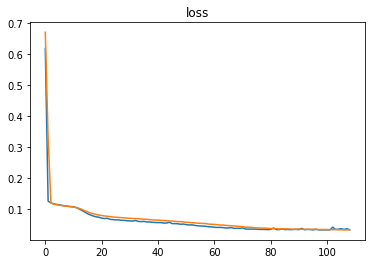

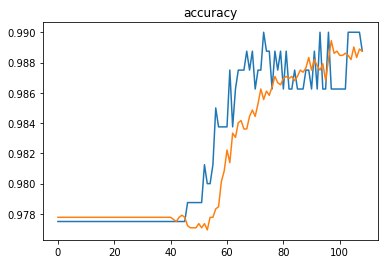

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot acc and loss
import matplotlib.pyplot as plt
epochs = range(len(history.history['loss']))
plt.plot(epochs , history.history['val_loss'])
plt.plot(epochs , history.history['loss'])
plt.title('loss')
plt.figure()
plt.plot(epochs , history.history['val_acc'])
plt.plot(epochs , history.history['acc'])
plt.title('accuracy')
plt.figure()
plt.show()

In [ ]:
model.evaluate(test_data , test_label)

74/74 [==============================] - 4s 37ms/step - loss: 0.0340 - acc: 0.9859


[0.03396012261509895, 0.9859215021133423]

In [ ]:
# performance measurements on test data 2

pred = model.predict(test_data)

thresh = find_opt_thresh(test_label , pred)
print(thresh)
prediction = np.zeros(np.shape(pred))
prediction[pred > thresh] = 1

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_label   , prediction)
print('accuracy is:' , np.round(accuracy*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import precision_score
pscore = precision_score(test_label   , prediction)
print('precision score is:' , np.round(pscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import recall_score
rscore = recall_score(test_label   , prediction)
print('recall score is:' , np.round(rscore*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import f1_score
fscore = f1_score(test_label   , prediction)
print('f1 score is:' , np.round(fscore*100,2) , '%')
print('___________________________________________')
spc = specificity_score(test_label   , prediction)
print('specificity is:' , np.round(spc*100,2) , '%')
print('___________________________________________')
sen = sensitivity_score(test_label   , prediction)
print('sensitivity is:' , np.round(sen*100,2) , '%')
print('___________________________________________')
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_label   , prediction)
print('AUC is:' , np.round(auc,4))

[0.35624602]
accuracy is: 98.81 %
___________________________________________
precision score is: 71.19 %
___________________________________________
recall score is: 79.25 %
___________________________________________
f1 score is: 75.0 %
___________________________________________
specificity is: 99.26 %
___________________________________________
sensitivity is: 79.25 %
___________________________________________
AUC is: 0.8925


#Statistics

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import os
from tqdm import tqdm
import numpy as np
import tensorflow as tf

In [ ]:
models_base_dir = '/content/drive/MyDrive/final_models/with_attention'

models_dir = []
for i in range(10):
  models_dir.append(os.path.join(models_base_dir , f'model{i+1}.h5'))

In [ ]:
models_dir

['/content/drive/MyDrive/final_models/with_attention/model1.h5',
 '/content/drive/MyDrive/final_models/with_attention/model2.h5',
 '/content/drive/MyDrive/final_models/with_attention/model3.h5',
 '/content/drive/MyDrive/final_models/with_attention/model4.h5',
 '/content/drive/MyDrive/final_models/with_attention/model5.h5',
 '/content/drive/MyDrive/final_models/with_attention/model6.h5',
 '/content/drive/MyDrive/final_models/with_attention/model7.h5',
 '/content/drive/MyDrive/final_models/with_attention/model8.h5',
 '/content/drive/MyDrive/final_models/with_attention/model9.h5',
 '/content/drive/MyDrive/final_models/with_attention/model10.h5']

In [ ]:
thresholds = []

for i in tqdm(range(10)):
  model = tf.keras.models.load_model(models_dir[i])
  pred = model.predict(test_data)
  thresh = find_opt_thresh(test_label , pred)
  thresholds.append(thresh)

100%|██████████| 10/10 [02:22<00:00, 14.28s/it]


In [ ]:
thresholds.append([0.5])

In [ ]:
thresholds

[[0.57995415],
 [0.11051235],
 [0.5123092],
 [0.5376344],
 [0.5073752],
 [0.47863552],
 [0.3256756],
 [0.29693928],
 [0.46206117],
 [0.35624647],
 [0.5]]

In [ ]:
for thresh in tqdm(thresholds[:6]):
  acc_list = []
  fscore_list = []
  spc_list = []
  auc_list = []
  for model_dir in models_dir:
    model = tf.keras.models.load_model(model_dir)
    pred = model.predict(test_data)
    prediction = np.zeros(np.shape(pred))
    prediction[pred > thresh] = 1
    accuracy = accuracy_score(test_label   , prediction)
    fscore = f1_score(test_label   , prediction)
    spc = specificity_score(test_label   , prediction)
    auc = roc_auc_score(test_label   , prediction)
    acc_list.append(accuracy)
    fscore_list.append(fscore)
    spc_list.append(spc)
    auc_list.append(auc)
  print('___________')
  print('Threshold:' , thresh)
  print('Accuracy:' , np.round(np.mean(acc_list)*100 , 2) , '%  +-' ,np.round(np.std(acc_list)*100 , 2) , '%')
  print('F1 Score:' , np.round(np.mean(fscore_list)*100 , 2) , '%  +-' ,np.round(np.std(fscore_list)*100 , 2) , '%')
  print('Specificity:' , np.round(np.mean(spc_list)*100 , 2) , '%  +-' ,np.round(np.std(spc_list)*100 , 2) , '%')
  print('AUC:' , np.round(np.mean(auc_list) , 4) , '+-' ,np.round(np.std(auc_list), 4) )

 17%|█▋        | 1/6 [01:46<08:53, 106.61s/it]

___________
Threshold: [0.57995415]
Accuracy: 98.79 %  +- 0.08 %
F1 Score: 72.23 %  +- 2.65 %
Specificity: 99.46 %  +- 0.12 %
AUC: 0.8464 +- 0.0291


 33%|███▎      | 2/6 [03:32<07:04, 106.07s/it]

___________
Threshold: [0.11051235]
Accuracy: 98.19 %  +- 0.34 %
F1 Score: 68.69 %  +- 3.9 %
Specificity: 98.45 %  +- 0.37 %
AUC: 0.9271 +- 0.008


 50%|█████     | 3/6 [05:18<05:18, 106.24s/it]

___________
Threshold: [0.5123092]
Accuracy: 98.79 %  +- 0.1 %
F1 Score: 73.18 %  +- 2.97 %
Specificity: 99.38 %  +- 0.1 %
AUC: 0.863 +- 0.0292


 67%|██████▋   | 4/6 [07:04<03:32, 106.06s/it]

___________
Threshold: [0.5376344]
Accuracy: 98.79 %  +- 0.1 %
F1 Score: 72.88 %  +- 2.99 %
Specificity: 99.41 %  +- 0.1 %
AUC: 0.8574 +- 0.0286


 83%|████████▎ | 5/6 [08:51<01:46, 106.44s/it]

___________
Threshold: [0.5073752]
Accuracy: 98.79 %  +- 0.09 %
F1 Score: 73.23 %  +- 2.8 %
Specificity: 99.38 %  +- 0.1 %
AUC: 0.8639 +- 0.029


100%|██████████| 6/6 [10:39<00:00, 106.65s/it]

___________
Threshold: [0.47863552]
Accuracy: 98.78 %  +- 0.1 %
F1 Score: 73.37 %  +- 2.4 %
Specificity: 99.34 %  +- 0.12 %
AUC: 0.8693 +- 0.0243


In [ ]:
for thresh in tqdm(thresholds[6:]):
  acc_list = []
  fscore_list = []
  spc_list = []
  auc_list = []
  for model_dir in models_dir:
    model = tf.keras.models.load_model(model_dir)
    pred = model.predict(test_data)
    prediction = np.zeros(np.shape(pred))
    prediction[pred > thresh] = 1
    accuracy = accuracy_score(test_label   , prediction)
    fscore = f1_score(test_label   , prediction)
    spc = specificity_score(test_label   , prediction)
    auc = roc_auc_score(test_label   , prediction)
    acc_list.append(accuracy)
    fscore_list.append(fscore)
    spc_list.append(spc)
    auc_list.append(auc)
  print('___________')
  print('Threshold:' , thresh)
  print('Accuracy:' , np.round(np.mean(acc_list)*100 , 2) , '%  +-' ,np.round(np.std(acc_list)*100 , 2) , '%')
  print('F1 Score:' , np.round(np.mean(fscore_list)*100 , 2) , '%  +-' ,np.round(np.std(fscore_list)*100 , 2) , '%')
  print('Specificity:' , np.round(np.mean(spc_list)*100 , 2) , '%  +-' ,np.round(np.std(spc_list)*100 , 2) , '%')
  print('AUC:' , np.round(np.mean(auc_list) , 4) , '+-' ,np.round(np.std(auc_list), 4) )

 20%|██        | 1/5 [01:45<07:02, 105.62s/it]

___________
Threshold: [0.3256756]
Accuracy: 98.69 %  +- 0.14 %
F1 Score: 73.51 %  +- 2.75 %
Specificity: 99.12 %  +- 0.15 %
AUC: 0.8966 +- 0.0244


 40%|████      | 2/5 [03:34<05:22, 107.52s/it]

___________
Threshold: [0.29693928]
Accuracy: 98.67 %  +- 0.18 %
F1 Score: 73.41 %  +- 3.1 %
Specificity: 99.08 %  +- 0.19 %
AUC: 0.9001 +- 0.0245


 60%|██████    | 3/5 [05:20<03:33, 106.94s/it]

___________
Threshold: [0.46206117]
Accuracy: 98.8 %  +- 0.08 %
F1 Score: 73.97 %  +- 1.8 %
Specificity: 99.33 %  +- 0.11 %
AUC: 0.875 +- 0.0192


#Statistics 2

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import os
from tqdm import tqdm
import numpy as np
import tensorflow as tf

In [ ]:
def find_optimal_threshold(y_true, y_score):
    thresholds = np.linspace(0, 1, 100)
    f1s = [f1_score(y_true, y_score > threshold) for threshold in thresholds]
    return thresholds[np.argmax(f1s)]

In [ ]:
models_base_dir = '/content/drive/MyDrive/final_models/with_attention'

models_dir = []
for i in range(10):
  models_dir.append(os.path.join(models_base_dir , f'model{i+1}.h5'))

In [ ]:
models_dir

['/content/drive/MyDrive/final_models/with_attention/model1.h5',
 '/content/drive/MyDrive/final_models/with_attention/model2.h5',
 '/content/drive/MyDrive/final_models/with_attention/model3.h5',
 '/content/drive/MyDrive/final_models/with_attention/model4.h5',
 '/content/drive/MyDrive/final_models/with_attention/model5.h5',
 '/content/drive/MyDrive/final_models/with_attention/model6.h5',
 '/content/drive/MyDrive/final_models/with_attention/model7.h5',
 '/content/drive/MyDrive/final_models/with_attention/model8.h5',
 '/content/drive/MyDrive/final_models/with_attention/model9.h5',
 '/content/drive/MyDrive/final_models/with_attention/model10.h5']

In [ ]:
thresholds = []

for i in tqdm(range(10)):
  model = tf.keras.models.load_model(models_dir[i])
  pred = model.predict(test_data)
  thresh = find_optimal_threshold(test_label , pred)
  thresholds.append(thresh)

100%|██████████| 10/10 [02:28<00:00, 14.82s/it]


In [ ]:
thresholds.append([0.5])

In [ ]:
thresholds

[0.5858585858585859,
 0.11111111111111112,
 0.5151515151515152,
 0.5353535353535354,
 0.5151515151515152,
 0.5252525252525253,
 0.3535353535353536,
 0.30303030303030304,
 0.4646464646464647,
 0.36363636363636365,
 [0.5]]

In [ ]:
for thresh in tqdm(thresholds[:6]):
  acc_list = []
  fscore_list = []
  spc_list = []
  auc_list = []
  for model_dir in models_dir:
    model = tf.keras.models.load_model(model_dir)
    pred = model.predict(test_data)
    prediction = np.zeros(np.shape(pred))
    prediction[pred > thresh] = 1
    accuracy = accuracy_score(test_label   , prediction)
    fscore = f1_score(test_label   , prediction)
    spc = specificity_score(test_label   , prediction)
    auc = roc_auc_score(test_label   , prediction)
    acc_list.append(accuracy)
    fscore_list.append(fscore)
    spc_list.append(spc)
    auc_list.append(auc)
  print('___________')
  print('Threshold:' , thresh)
  print('Accuracy:' , np.round(np.mean(acc_list)*100 , 2) , '%  +-' ,np.round(np.std(acc_list)*100 , 2) , '%')
  print('F1 Score:' , np.round(np.mean(fscore_list)*100 , 2) , '%  +-' ,np.round(np.std(fscore_list)*100 , 2) , '%')
  print('Specificity:' , np.round(np.mean(spc_list)*100 , 2) , '%  +-' ,np.round(np.std(spc_list)*100 , 2) , '%')
  print('AUC:' , np.round(np.mean(auc_list) , 4) , '+-' ,np.round(np.std(auc_list), 4) )

 17%|█▋        | 1/6 [01:48<09:02, 108.54s/it]

___________
Threshold: 0.5858585858585859
Accuracy: 98.79 %  +- 0.08 %
F1 Score: 72.1 %  +- 2.88 %
Specificity: 99.47 %  +- 0.11 %
AUC: 0.8445 +- 0.0308


 33%|███▎      | 2/6 [03:36<07:12, 108.16s/it]

___________
Threshold: 0.11111111111111112
Accuracy: 98.19 %  +- 0.33 %
F1 Score: 68.74 %  +- 3.88 %
Specificity: 98.45 %  +- 0.36 %
AUC: 0.9272 +- 0.008


 50%|█████     | 3/6 [05:24<05:23, 107.98s/it]

___________
Threshold: 0.5151515151515152
Accuracy: 98.79 %  +- 0.1 %
F1 Score: 73.18 %  +- 2.97 %
Specificity: 99.38 %  +- 0.1 %
AUC: 0.863 +- 0.0292


 67%|██████▋   | 4/6 [07:10<03:34, 107.22s/it]

___________
Threshold: 0.5353535353535354
Accuracy: 98.79 %  +- 0.1 %
F1 Score: 72.92 %  +- 3.0 %
Specificity: 99.41 %  +- 0.1 %
AUC: 0.8584 +- 0.0289


 83%|████████▎ | 5/6 [08:57<01:47, 107.27s/it]

___________
Threshold: 0.5151515151515152
Accuracy: 98.79 %  +- 0.1 %
F1 Score: 73.18 %  +- 2.97 %
Specificity: 99.38 %  +- 0.1 %
AUC: 0.863 +- 0.0292


100%|██████████| 6/6 [10:46<00:00, 107.69s/it]

___________
Threshold: 0.5252525252525253
Accuracy: 98.81 %  +- 0.09 %
F1 Score: 73.33 %  +- 2.8 %
Specificity: 99.4 %  +- 0.1 %
AUC: 0.8621 +- 0.0289


In [ ]:
for thresh in tqdm(thresholds[6:]):
  acc_list = []
  fscore_list = []
  spc_list = []
  auc_list = []
  for model_dir in models_dir:
    model = tf.keras.models.load_model(model_dir)
    pred = model.predict(test_data)
    prediction = np.zeros(np.shape(pred))
    prediction[pred > thresh] = 1
    accuracy = accuracy_score(test_label   , prediction)
    fscore = f1_score(test_label   , prediction)
    spc = specificity_score(test_label   , prediction)
    auc = roc_auc_score(test_label   , prediction)
    acc_list.append(accuracy)
    fscore_list.append(fscore)
    spc_list.append(spc)
    auc_list.append(auc)
  print('___________')
  print('Threshold:' , thresh)
  print('Accuracy:' , np.round(np.mean(acc_list)*100 , 2) , '%  +-' ,np.round(np.std(acc_list)*100 , 2) , '%')
  print('F1 Score:' , np.round(np.mean(fscore_list)*100 , 2) , '%  +-' ,np.round(np.std(fscore_list)*100 , 2) , '%')
  print('Specificity:' , np.round(np.mean(spc_list)*100 , 2) , '%  +-' ,np.round(np.std(spc_list)*100 , 2) , '%')
  print('AUC:' , np.round(np.mean(auc_list) , 4) , '+-' ,np.round(np.std(auc_list), 4) )

 20%|██        | 1/5 [01:48<07:12, 108.10s/it]

___________
Threshold: 0.3535353535353536
Accuracy: 98.71 %  +- 0.13 %
F1 Score: 73.52 %  +- 2.57 %
Specificity: 99.15 %  +- 0.13 %
AUC: 0.8929 +- 0.0223
